# 可视化模型的 Scale&Shift 参数
## ViT-b16

### 导入库文件

In [1]:
%cd /home/hjy/SSF
import sys
import os
PROJECT_ROOT="/home/wyh/PEFT/SSF"
PROJECT_ROOT="/home/wyh/SSF"
SAVED_ROOT="/media/disk1/wyh/SSF"
sys.path.append(PROJECT_ROOT)
import torch
import timm
from timm.models import create_model, safe_model_name, resume_checkpoint, load_checkpoint,\
    convert_splitbn_model, model_parameters
from models import vision_transformer, swin_transformer, convnext, as_mlp
from models.lora import LoRA_ViT_timm
import numpy as np


import warnings
warnings. filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.models as models


/home/hjy/SSF


### 工具函数

In [3]:
# 从模型中获取权重(不适用于Lora后)
def get_scale_dict(path):
    model = create_model(
        MODEL_NAME,
        pretrained=True,
        num_classes=NUM_CLASSES,
        drop_rate=0.0,
        drop_path_rate=0.0,
        drop_block_rate=None,
        global_pool=None,
        bn_momentum=None,
        bn_eps=None,
        scriptable=False,
        checkpoint_path='',
        tuning_mode=METHOD_NAME)
    resume_epoch = resume_checkpoint(
        model, path,
        optimizer=None,
        loss_scaler=None,
        log_info=True)
    
    ssf_scale,ssf_scale_masked={},{}
    for name, para in model.named_parameters():
        if "ssf_scale" in name:
            temp=para.data.detach().cpu().numpy()
            ssf_scale[name]=temp
            ssf_scale_masked[name]=temp[temp!=0]
    return ssf_scale,ssf_scale_masked

# 直接读取ckpt(通用)
def get_from_ckpt(path):
    ckpt = torch.load(path, map_location='cpu')
    state_dict=ckpt['state_dict']
    ssf_scale,ssf_scale_masked={},{}
    for (name,para) in state_dict.items():
        if 'ssf_scale' in name:
            temp=para.data.detach().cpu().numpy()
            ssf_scale[name]=temp
            ssf_scale_masked[name]=temp[temp!=0]
    return  ssf_scale,ssf_scale_masked

# 画分布图
def draw(dict):
    arr,name=[],[]
    for key,val in dict.items():
        name.append(key)
        arr.append(val)
    up_mean=np.mean(np.array([a.max() for a in arr]))
    lw_mean=np.mean(np.array([a.min() for a in arr]))
    num_rows = len(arr)
    fig, axs = plt.subplots(ncols=num_rows, nrows=1, sharey=True,gridspec_kw={"hspace": 0, "wspace": 0})
    fig.set_size_inches(20, 4)
    lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
    ran=(lw,up_mean*1.5)
    ran=(lw,up_mean*1.5)
    for i in range(num_rows):
        # sns.histplot(y=arr[i], ax=axs[i], kde=True, stat="density")
        # sns.distplot(arr[i], ax=axs[i], kde=True, stat="density",hist_kws={'range': (0.0, 0.2)})
        color="blue"
        if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
            color="red"
        sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color)
        # sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color,\
        #     hist_kws={'range': ran},kde_kws={'clip': ran})
        # sns.histplot(data, clip=(0, 10))
        axs[i].set_xticks([])
        # axs[i].set_xlabel(f"{i+1}")
        label=""
        if 'attn' in name[i]:
            label+="a"
        elif 'mlp' in name[i]:
            label+="m"
        else:
            label+="b"
        label+=name[i].split("_")[-1]
        axs[i].set_xlabel(label)
    plt.tight_layout()
    # sns.set_style('white')
    sns.set(style='whitegrid')
    sns.despine(right=True,left=True)
    plt.show()
    # list=np.hstack(arr)
    # print("MAX Scale: ", list.max())
    # print("MIN Scale: ", list.min())
    # print("AVE Scale: ", np.mean(list))
    # print("VAR Scale: ", np.var(list))

# 逐层统计学分析
def max_min_ave_var(dict):
    list=[]
    for name,val in dict.items():
        print(f'{name:30} Len:{val.shape[0]:5}   Max:{max(val):2.3f}   Min:{min(val):2.3f}  Ave:{np.mean(val):2.3f}  Var:{np.var(val):2.3f}')
        list.append(val)
    list=np.hstack(list)
    print("MAX Scale: ", list.max())
    print("MIN Scale: ", list.min())
    print("AVE Scale: ", np.mean(list))
    print("VAR Scale: ", np.var(list))
    
# 整体统计学分析
def max_min_ave_var_all(dict):
    list=[]
    for name,val in dict.items():
        # print(f'{name:30} Len:{val.shape[0]:5}   Max:{max(val):2.3f}   Min:{min(val):2.3f}  Ave:{np.mean(val):2.3f}  Var:{np.var(val):2.3f}')
        list.append(val)
    list=np.hstack(list)
    print("MAX Scale: ", list.max())
    print("MIN Scale: ", list.min())
    print("AVE Scale: ", np.mean(list))
    print("VAR Scale: ", np.var(list))
    
 # 画图后统计学分析   
def draw_and_max_min_ave_var(dict):
    draw(dict)
    max_min_ave_var(dict)



### 环境变量

In [13]:
MODEL_NAME = "vit_base_patch16_224_in21k"
MODEL_PATH = "/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/caltech101/ssf/20230811-034730-vit_base_patch16_224_in21k-224/last.pth.tar"
# pruning with reg + rec
cd0 = "/data/hjy/SSF/ckpts/cifar_100/baseline-ssf-93.88.pth.tar"
# retrain full ssf
cd1 = "/data/hjy/SSF/ckpts/cifar_100/rec=0.7-epoch279.pth.tar"
# retrain + lora
cd2 = "/data/hjy/SSF/vit_base_patch16_224_in21k/vtab/caltech101/ssf/20230811-034730-vit_base_patch16_224_in21k-224/model_best.pth.tar"

METHOD_NAME = "ssf"
NUM_CLASSES = 100

### 获取数据

In [14]:
cd_0, cd_0_masked = get_scale_dict(cd0)
cd_1, cd_1_masked = get_scale_dict(cd1)
cd_2, cd_2_masked = get_from_ckpt(cd2)

### 整体统计学分析

In [15]:
print('==============================Reg+Rec======================')
max_min_ave_var_all(cd_0)
# print('==========================Reg+Rec  Masked==================')
# max_min_ave_var_all(cd_0_masked)
print('=========================Retrain_Full======================')
max_min_ave_var_all(cd_1)
# print('=========================Retrain_Full  Masked==============')
# max_min_ave_var_all(cd_1_masked)
print('===========================Retrain_Lora====================')
max_min_ave_var_all(cd_2)
# print('=======================Retrain_Lora  Masked================')
# max_min_ave_var_all(cd_2_masked)

==============================Reg+Rec======================
MAX Scale:  1.16577
MIN Scale:  0.855535
AVE Scale:  1.0011553
VAR Scale:  0.0007891457
=========================Retrain_Full======================
MAX Scale:  1.7404141
MIN Scale:  -0.0006803492
AVE Scale:  0.028861396
VAR Scale:  0.0025247238
===========================Retrain_Lora====================
MAX Scale:  1.16577
MIN Scale:  0.855535
AVE Scale:  1.0011553
VAR Scale:  0.0007891457


### 权重分布图

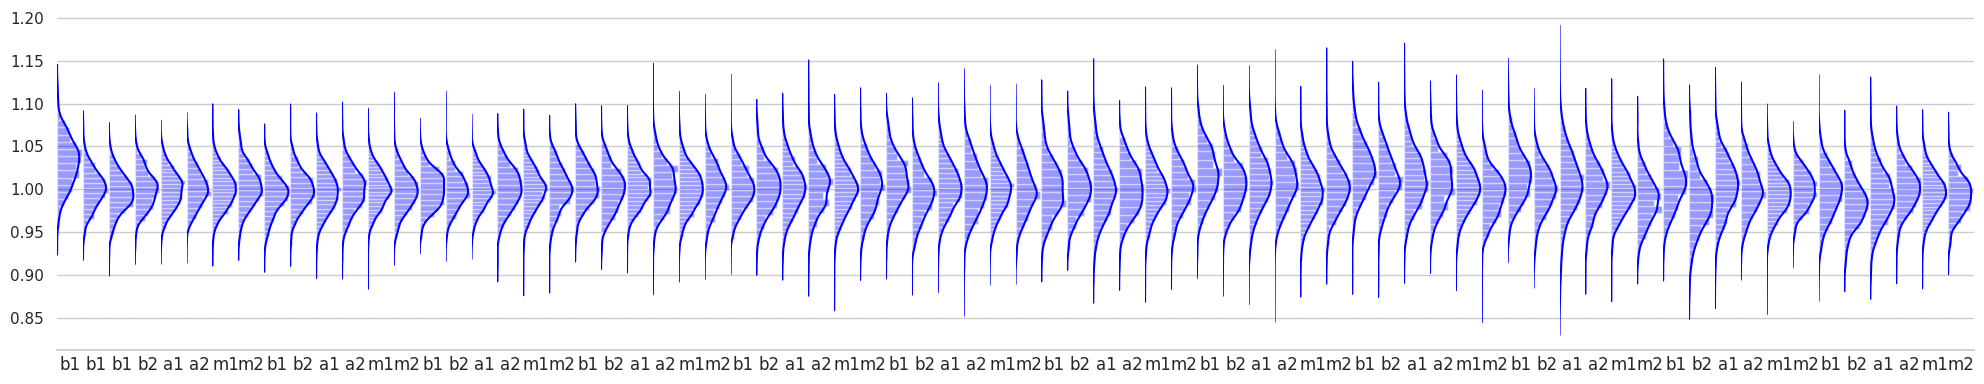

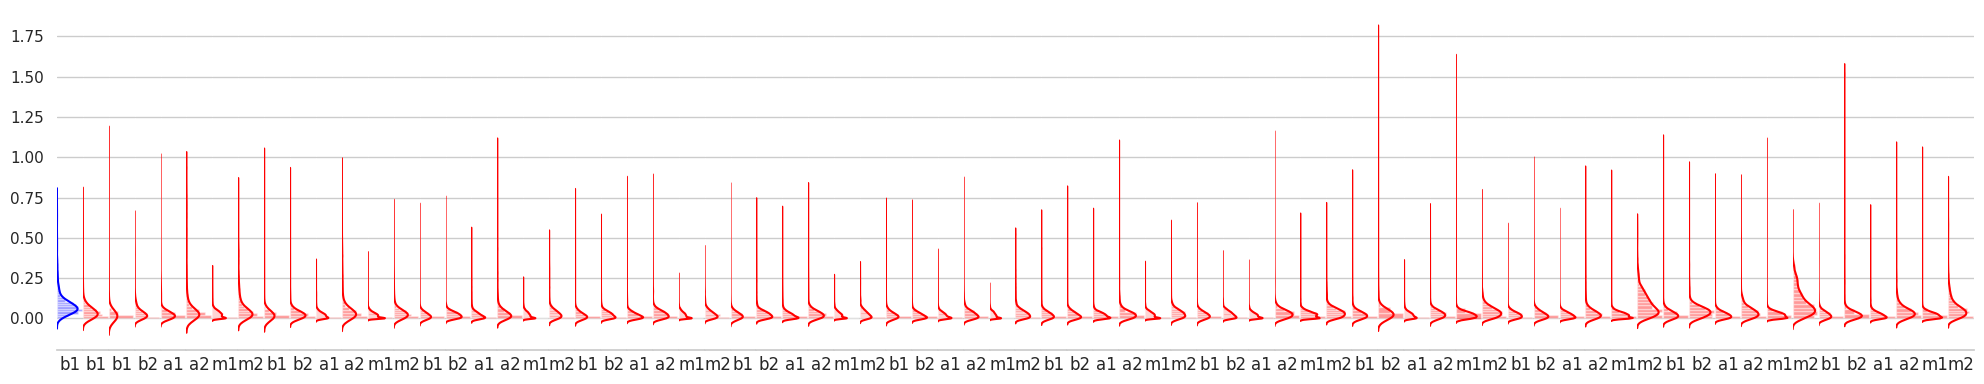

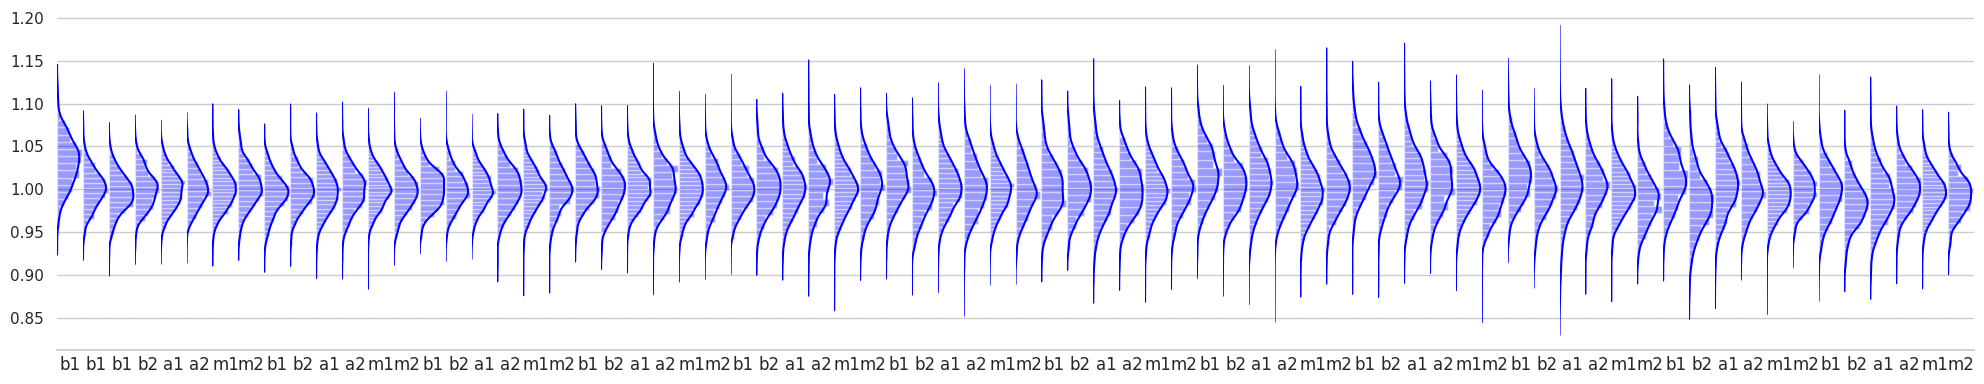

In [16]:
draw(cd_0)
# draw(cd_0_masked)
draw(cd_1)
# draw(cd_1_masked)
draw(cd_2)
# draw(cd_2_masked)

### 先画图再分析

==============================Reg+Rec======================


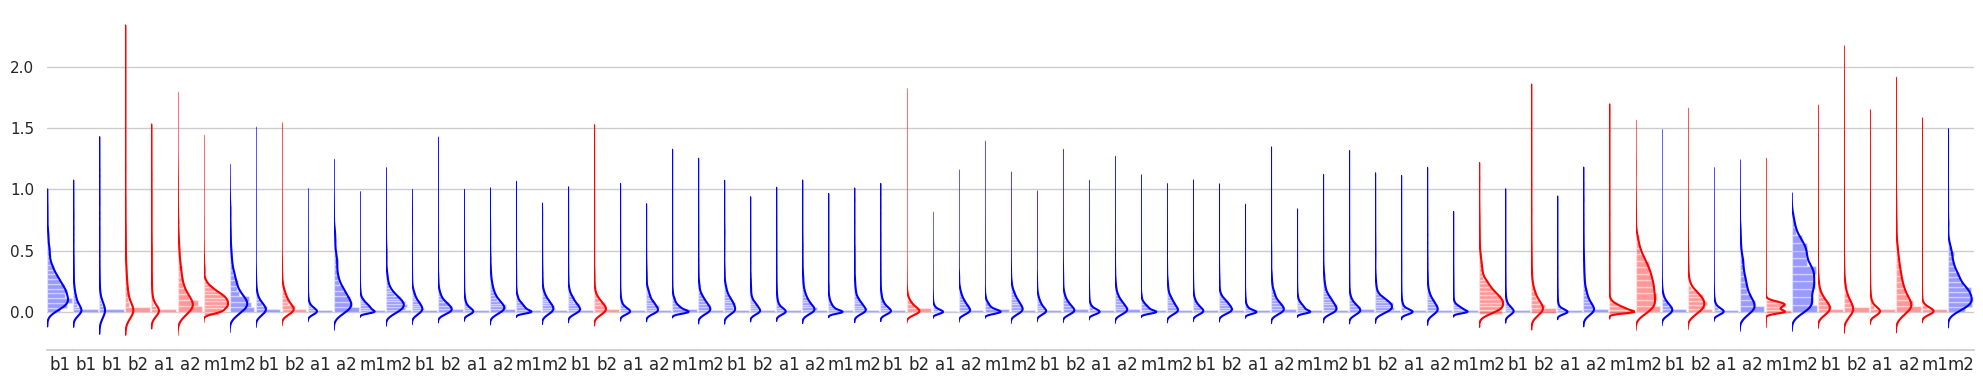

ssf_scale_1                    Len:  768   Max:0.886   Min:-0.000  Ave:0.197  Var:0.021
patch_embed.ssf_scale_1        Len:  768   Max:0.954   Min:-0.000  Ave:0.090  Var:0.022
blocks.0.ssf_scale_1           Len:  768   Max:1.252   Min:-0.000  Ave:0.100  Var:0.048
blocks.0.ssf_scale_2           Len:  768   Max:2.152   Min:-0.000  Ave:0.132  Var:0.052
blocks.0.attn.ssf_scale_1      Len: 2304   Max:1.398   Min:-0.000  Ave:0.106  Var:0.042
blocks.0.attn.ssf_scale_2      Len:  768   Max:1.606   Min:-0.000  Ave:0.200  Var:0.053
blocks.0.mlp.ssf_scale_1       Len: 3072   Max:1.380   Min:-0.022  Ave:0.109  Var:0.009
blocks.0.mlp.ssf_scale_2       Len:  768   Max:1.042   Min:-0.000  Ave:0.191  Var:0.041
blocks.1.ssf_scale_1           Len:  768   Max:1.385   Min:-0.000  Ave:0.080  Var:0.023
blocks.1.ssf_scale_2           Len:  768   Max:1.435   Min:-0.000  Ave:0.089  Var:0.018
blocks.1.attn.ssf_scale_1      Len: 2304   Max:0.931   Min:-0.000  Ave:0.055  Var:0.013
blocks.1.attn.ssf_scale_2      L

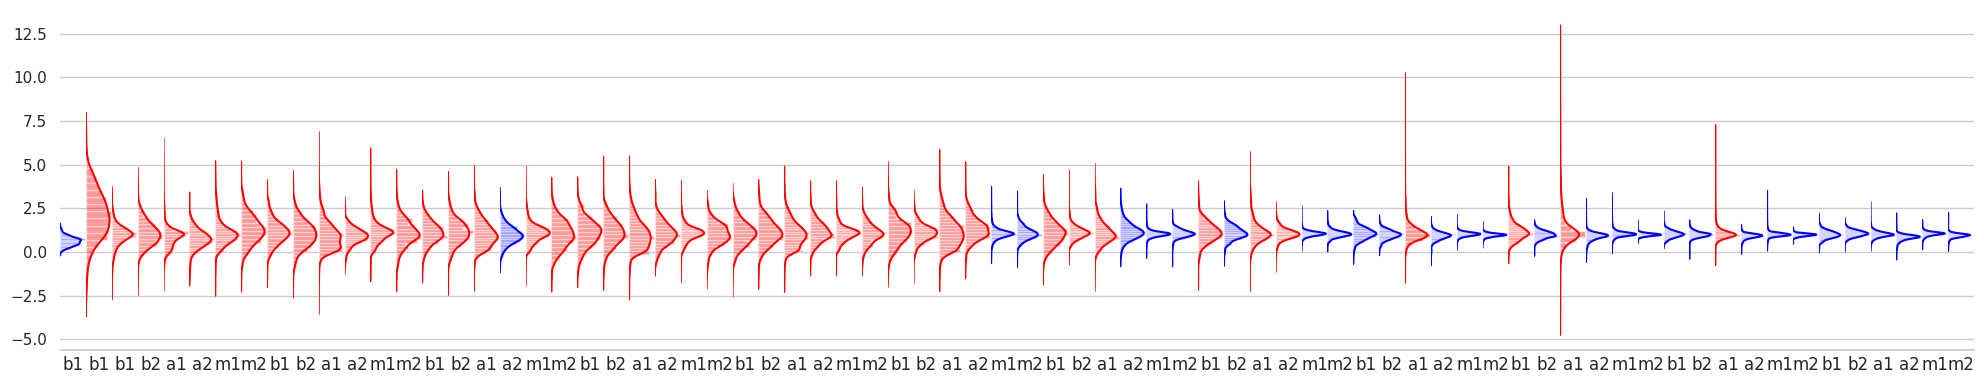

ssf_scale_1                    Len:  768   Max:1.408   Min:0.006  Ave:0.612  Var:0.069
patch_embed.ssf_scale_1        Len:  768   Max:6.838   Min:-2.588  Ave:2.131  Var:2.010
blocks.0.ssf_scale_1           Len:  768   Max:3.222   Min:-2.218  Ave:0.930  Var:0.409
blocks.0.ssf_scale_2           Len:  768   Max:4.236   Min:-1.900  Ave:1.053  Var:0.545
blocks.0.attn.ssf_scale_1      Len: 2304   Max:6.043   Min:-1.763  Ave:0.847  Var:0.521
blocks.0.attn.ssf_scale_2      Len:  768   Max:2.947   Min:-1.465  Ave:0.738  Var:0.326
blocks.0.mlp.ssf_scale_1       Len: 3072   Max:4.755   Min:-2.048  Ave:1.064  Var:0.578
blocks.0.mlp.ssf_scale_2       Len:  768   Max:4.516   Min:-1.609  Ave:1.268  Var:0.706
blocks.1.ssf_scale_1           Len:  768   Max:3.566   Min:-1.459  Ave:1.118  Var:0.492
blocks.1.ssf_scale_2           Len:  768   Max:4.004   Min:-1.970  Ave:1.034  Var:0.669
blocks.1.attn.ssf_scale_1      Len: 2304   Max:6.335   Min:-3.011  Ave:0.946  Var:0.737
blocks.1.attn.ssf_scale_2      Le

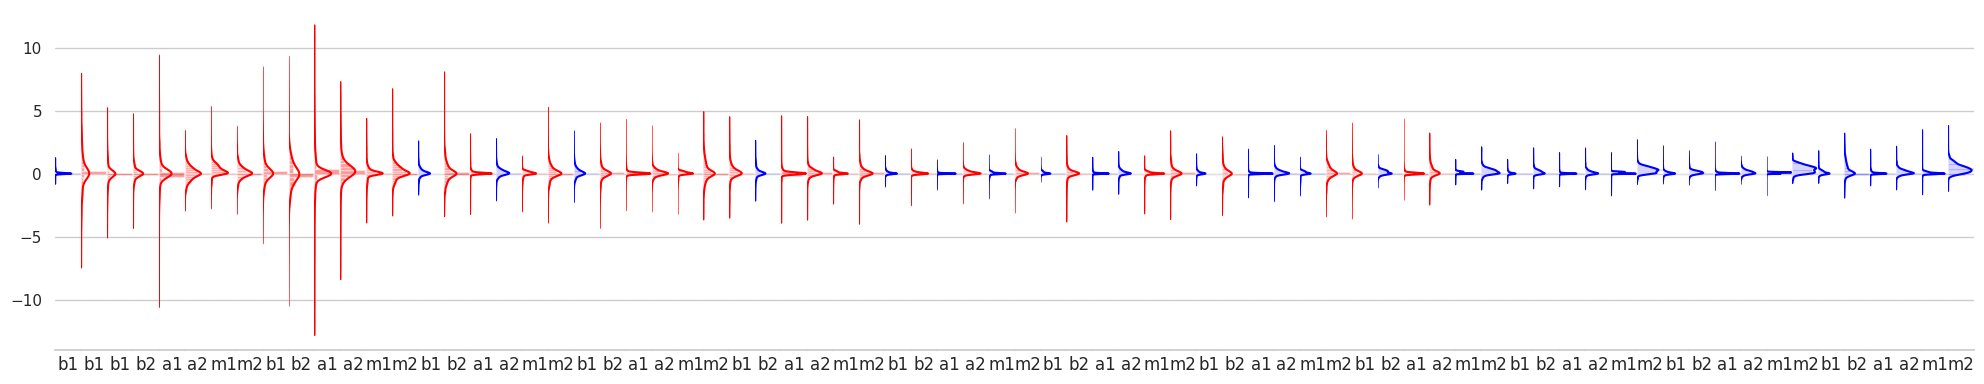

ssf_scale_1                    Len:  768   Max:1.145   Min:-0.717  Ave:0.034  Var:0.012
patch_embed.ssf_scale_1        Len:  768   Max:6.677   Min:-6.198  Ave:0.179  Var:2.481
blocks.0.ssf_scale_1           Len:  768   Max:4.458   Min:-4.321  Ave:-0.030  Var:0.878
blocks.0.ssf_scale_2           Len:  768   Max:4.138   Min:-3.747  Ave:0.047  Var:0.530
blocks.0.attn.ssf_scale_1      Len: 2304   Max:8.432   Min:-9.639  Ave:0.142  Var:2.189
blocks.0.attn.ssf_scale_2      Len:  768   Max:2.907   Min:-2.445  Ave:0.022  Var:0.366
blocks.0.mlp.ssf_scale_1       Len: 3072   Max:4.933   Min:-2.407  Ave:0.326  Var:0.351
blocks.0.mlp.ssf_scale_2       Len:  768   Max:3.225   Min:-2.704  Ave:0.105  Var:0.390
blocks.1.ssf_scale_1           Len:  768   Max:7.506   Min:-4.604  Ave:0.118  Var:1.384
blocks.1.ssf_scale_2           Len:  768   Max:7.892   Min:-9.100  Ave:-0.007  Var:3.033
blocks.1.attn.ssf_scale_1      Len: 2304   Max:10.913   Min:-11.957  Ave:0.070  Var:1.768
blocks.1.attn.ssf_scale_2   

In [7]:
print('==============================Reg+Rec======================')
draw_and_max_min_ave_var(cd_0)
# print('==========================Reg+Rec  Masked==================')
# draw_and_max_min_ave_var(cd_0_masked)
print('=========================Retrain_Full======================')
draw_and_max_min_ave_var(cd_1)
# print('=========================Retrain_Full  Masked==============')
# draw_and_max_min_ave_var(cd_1_masked)
print('===========================Retrain_Lora====================')
draw_and_max_min_ave_var(cd_2)
# print('=======================Retrain_Lora  Masked================')
# draw_and_max_min_ave_var(cd_2_masked)

### 逐层统计学分析

In [ ]:
print('==============================Reg+Rec======================')
max_min_ave_var(cd_0)
print('==========================Reg+Rec  Masked==================')
max_min_ave_var(cd_0_masked)
print('=========================Retrain_Full======================')
max_min_ave_var(cd_1)
print('=========================Retrain_Full  Masked==============')
max_min_ave_var(cd_1_masked)
print('===========================Retrain_Lora====================')
max_min_ave_var(cd_2)
print('=======================Retrain_Lora  Masked================')
max_min_ave_var(cd_2_masked)

### Something Useless

In [ ]:
model = create_model(
        MODEL_NAME,
        pretrained=True,
        num_classes=NUM_CLASSES,
        drop_rate=0.0,
        drop_path_rate=0.0,
        drop_block_rate=None,
        global_pool=None,
        bn_momentum=None,
        bn_eps=None,
        scriptable=False,
        checkpoint_path='',
        tuning_mode=METHOD_NAME)
resume_epoch = resume_checkpoint(
    model, cd1,
    optimizer=None,
    loss_scaler=None,
    log_info=True)

In [ ]:
# for i,(name,module) in enumerate(model.named_modules()) :
#     # print(name)
#     cw=False
#     for m in module.children():
#         if hasattr(m,"weight"):
#             cw=True
#     if cw:
#     # if hasattr(module,"weight"):
#         print(i,"\t",name)
#         print("PARAMETER: ")
#         for n,p in module.named_parameters():
#             print(n,"\t",p.shape)
#         print("DICT:")
#         # print(type(module.weight),module.weight.size())
#         for k in module.__dict__:
#             print("\t",k)
# for j,(name,parameters) in enumerate(model.named_parameters()):
#     key=["ssf_scale","ssf_scale"]
#     if any([k in name for k in key]):
#         print("{}\t{}\t{}\t{}".format(j,name,parameters.shape,parameters.data.shape))        
    

In [ ]:
ssf_scale,ssf_shift={},{}
for name, para in model.named_parameters():
    if "ssf_scale" in name:
        ssf_scale[name]=para.data.detach().cpu().numpy()
    elif "ssf_shift" in name:
        ssf_shift[name]=para.data.detach().cpu().numpy()
    else:
        pass

In [ ]:
# show basic info of ssf_scale and ssf_shift:
print("Length: ",len(ssf_scale),"\t",len(ssf_shift))
print("SSF_SCALE:")
for k in ssf_scale:
    print(k,ssf_scale[k].shape)
print("SSF_SHIFT:")
for k in ssf_shift:
    print(k,ssf_shift[k].shape)

In [ ]:
import warnings
warnings. filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.models as models

def draw6(row1,name=None):
    data=row1
    arr = data
    up_mean=np.mean(np.array([a.max() for a in arr]))
    lw_mean=np.mean(np.array([a.min() for a in arr]))
    num_rows = len(arr)
    fig, axs = plt.subplots(ncols=num_rows, nrows=1, sharey=True,gridspec_kw={"hspace": 0, "wspace": 0})
    fig.set_size_inches(20, 4)
    lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
    ran=(lw,up_mean*1.5)
    ran=(lw,up_mean*1.5)
    for i in range(num_rows):
        # sns.histplot(y=arr[i], ax=axs[i], kde=True, stat="density")
        # sns.distplot(arr[i], ax=axs[i], kde=True, stat="density",hist_kws={'range': (0.0, 0.2)})
        color="blue"
        if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
            color="red"
        sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color)
        # sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color,\
        #     hist_kws={'range': ran},kde_kws={'clip': ran})
        # sns.histplot(data, clip=(0, 10))
        axs[i].set_xticks([])
        # axs[i].set_xlabel(f"{i+1}")
        label=""
        if 'attn' in name[i]:
            label+="a"
        elif 'mlp' in name[i]:
            label+="m"
        else:
            label+="b"
        label+=name[i].split("_")[-1]
        axs[i].set_xlabel(label)
    plt.tight_layout()
    # sns.set_style('white')
    sns.set(style='whitegrid')
    sns.despine(right=True,left=True)
    plt.show()
ssf_scale_list,ssf_shift_list,ssf_scale_name,ssf_shift_name=[],[],[],[]
for name, para in model.named_parameters():
    if "ssf_scale" in name:
        ssf_scale_list.append(para.data.detach().cpu().numpy())
        ssf_scale_name.append(name)
    elif "ssf_shift" in name:
        ssf_shift_list.append(para.data.detach().cpu().numpy())
        ssf_shift_name.append(name)
    else:
        pass
draw6(ssf_scale_list,ssf_scale_name)
draw6(ssf_shift_list,ssf_shift_name)
print("MAX Scale: ", max([s.max() for s in ssf_scale_list]))
print("MIN Scale: ", min([s.min() for s in ssf_scale_list]))
print("MAX Shift: ", max([s.max() for s in ssf_shift_list]))
print("MIN Shift: ", min([s.min() for s in ssf_shift_list]))

In [ ]:
# print("MIN Scale: ", min([s.min() for s in ssf_scale_list]))
# print("MAX Shift: ", max([s.max() for s in ssf_shift_list]))
sc_num=0
sc_pnm=0
for i,(sc,sh) in enumerate(zip(ssf_scale_list,ssf_shift_list)):
    # select indexes from sc, where abs value is less than 0.02
    # indexes=np.where(np.abs(sc)<0.02)
    indexes=np.argwhere(np.abs(sc)<0.01)
    subsc=np.take(sc,indexes)
    sc_pnm+=len(subsc)
    sc_num+=len(sc)
    subsh=np.take(sh,indexes)
    
    # subsh=np.take(sh,indexes)
    print("{:.2f} Layer {}:\t{}/{}\t{:.2f}%".format(np.abs(subsh).mean(), i,len(subsc),len(sc),len(subsc)/len(sc)*100))
print("Total:\t{}/{}\t{:.2f}%".format(sc_pnm,sc_num,sc_pnm/sc_num*100))

In [ ]:
# def print_outler(row1,name=None):
#     data=row1
#     arr = data
#     up_mean=np.mean(np.array([a.max() for a in arr]))
#     lw_mean=np.mean(np.array([a.min() for a in arr]))
#     num_rows = len(arr)
#     lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
#     ran=(lw,up_mean*1.5)
#     for i in range(len(row1)):
#         if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
#             print(name[i])
# print_outler(ssf_scale_list,ssf_scale_name)
# print_outler(ssf_shift_list,ssf_shift_name)


#### 运行计时
5.23 00:35 开始运行 ./train_scripts/vit/cifar_vtab

In [ ]:
def get_scale_list(path):
    model = create_model(
        MODEL_NAME,
        pretrained=True,
        num_classes=NUM_CLASSES,
        drop_rate=0.0,
        drop_path_rate=0.0,
        drop_block_rate=None,
        global_pool=None,
        bn_momentum=None,
        bn_eps=None,
        scriptable=False,
        checkpoint_path='',
        tuning_mode=METHOD_NAME)
    resume_epoch = resume_checkpoint(
        model, path,
        optimizer=None,
        loss_scaler=None,
        log_info=True)
    
    ssf_scale,ssf_scale_masked=[],[]
    for name, para in model.named_parameters():
        if "ssf_scale" in name:
            temp=para.data.detach().cpu().numpy()
            ssf_scale.append(temp)
            ssf_scale_masked.append(temp[temp!=0])
    
    return  ssf_scale,ssf_scale_masked

In [ ]:
def draw(dict):
    arr,name=[],[]
    for key,val in dict.items():
        name.append(key)
        arr.append(val)
    up_mean=np.mean(np.array([a.max() for a in arr]))
    lw_mean=np.mean(np.array([a.min() for a in arr]))
    num_rows = len(arr)
    fig, axs = plt.subplots(ncols=num_rows, nrows=1, sharey=True,gridspec_kw={"hspace": 0, "wspace": 0})
    fig.set_size_inches(20, 4)
    lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
    ran=(lw,up_mean*1.5)
    ran=(lw,up_mean*1.5)
    for i in range(num_rows):
        # sns.histplot(y=arr[i], ax=axs[i], kde=True, stat="density")
        # sns.distplot(arr[i], ax=axs[i], kde=True, stat="density",hist_kws={'range': (0.0, 0.2)})
        color="blue"
        if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
            color="red"
        sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color)
        # sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color,\
        #     hist_kws={'range': ran},kde_kws={'clip': ran})
        # sns.histplot(data, clip=(0, 10))
        axs[i].set_xticks([])
        # axs[i].set_xlabel(f"{i+1}")
        label=""
        if 'attn' in name[i]:
            label+="a"
        elif 'mlp' in name[i]:
            label+="m"
        else:
            label+="b"
        label+=name[i].split("_")[-1]
        axs[i].set_xlabel(label)
    plt.tight_layout()
    # sns.set_style('white')
    sns.set(style='whitegrid')
    sns.despine(right=True,left=True)
    plt.show()
    print("MAX Scale: ", max([s.max() for s in arr]))
    print("MIN Scale: ", min([s.min() for s in arr]))
    print("AVE Scale: ", sum([sum(s) for s in arr])/sum([len(s) for s in arr]))

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(161)
draw(cd_0)
plt.title('0')
plt.subplot(162)
draw(cd_0_masked)
plt.title('0_masked')
plt.subplot(163)
draw(cd_1)
plt.title('1')
plt.subplot(164)
draw(cd_1_masked)
plt.title('1_masked')
plt.subplot(165)
draw(cd_2)
plt.title('2')
plt.subplot(166)
draw(cd_2_masked)
plt.title('2_masked')
plt.show()

In [ ]:
def draw1():
    sarr,arr,name=[],[],[]
    for dict in [cd_0,cd_0_masked,cd_1,cd_1_masked,cd_2,cd_2_masked]:
        for key,val in dict.items():
            name.append(key)
            arr.append(val)
        sarr.append(arr)
    up_mean=np.mean(np.array([a.max() for a in arr]))
    lw_mean=np.mean(np.array([a.min() for a in arr]))
    num_rows = len(arr)
    rows=6
    fig, axs = plt.subplots(ncols=num_rows, nrows=6, sharey=True,gridspec_kw={"hspace": 0, "wspace": 0})
    fig.set_size_inches(20, 4)
    lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
    ran=(lw,up_mean*1.5)
    ran=(lw,up_mean*1.5)
    for j in range(rows):
        arr=sarr[j]
        for i in range(num_rows):
            color="blue"
            if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
                color="red"
            sns.distplot(arr[i], ax=axs[i,j], kde=True, vertical=True,color=color)
            axs[i,j].set_xticks([])
            label=""
            if 'attn' in name[i]:
                label+="a"
            elif 'mlp' in name[i]:
                label+="m"
            else:
                label+="b"
            label+=name[i].split("_")[-1]
            axs[i,j].set_xlabel(label)
        break
    plt.tight_layout()
    # sns.set_style('white')
    sns.set(style='whitegrid')
    sns.despine(right=True,left=True)
    plt.show()
    print("MAX Scale: ", max([s.max() for s in arr]))
    print("MIN Scale: ", min([s.min() for s in arr]))
    print("AVE Scale: ", sum([sum(s) for s in arr])/sum([len(s) for s in arr]))
draw1()